In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks')
from central_import import *

figure_directory = '../../Figures/ModelCompare/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
#Calling the input file and shuffling the dataset
data = pd.read_parquet('../DataBuild/SciFiTrackTrainingData.parquet').sample(frac=1,random_state=51)


#Defining Target Variable
x=data.drop(['isMatched'],axis=1)
y=data['isMatched'].astype(int)

columns=np.array(['SciFiHits','Tx','Ty','X', 'Y','Eta','Phi','Chi2PerDoF'])
x.columns=columns

#Training Data
print(f"Dimension of the Data is : ",x.shape)
display(x.head())


Dimension of the Data is :  (87135, 8)


,SciFiHits,Tx,Ty,X,Y,Eta,Phi,Chi2PerDoF
49151,12,-0.060411,0.013421,-153.548538,105.998650,3.476598,2.922976,0.102292
85137,12,-0.061031,-0.025504,-135.147995,-185.306839,3.410142,-2.745762,0.728882
42850,12,0.136115,-0.001598,207.999268,-7.964487,2.691931,-0.011739,0.341895
34122,12,0.139153,-0.012004,198.540390,-61.761887,2.666461,-0.086049,1.730908
2555,11,0.163843,-0.000410,400.321808,-8.361286,2.508637,-0.002505,0.133988


In [3]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=51)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=51)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

In [4]:
rocScores=[]
f1Scores=[]
for model in models_:
    model.fit(x_train,y_train)
    # Model Evaluation (Balanced Data)
    y_predict=model.predict(x_test)
    rocScores.append(round(roc_auc_score(y_test,y_predict)*100,2))
    f1Scores.append(round(f1_score(y_test,y_predict)*100,2))
    print(model)
    print(f'ROC-AUC Score : ',round(roc_auc_score(y_test,y_predict)*100,2),'%')
    print(f'F1 Score : ',round(f1_score(y_test,y_predict)*100,2),'%')

modelMetrics=pd.DataFrame(modelNames,columns=["ModelNames"])
modelMetrics['ROC']=rocScores
modelMetrics['F1']=f1Scores
modelMetrics.to_csv("ModelMetrics.csv",index=False)


LogisticRegression()
ROC-AUC Score :  91.11 %
F1 Score :  93.77 %
DecisionTreeClassifier()
ROC-AUC Score :  89.12 %
F1 Score :  93.72 %
RandomForestClassifier()
ROC-AUC Score :  93.83 %
F1 Score :  96.44 %
GradientBoostingClassifier()
ROC-AUC Score :  93.32 %
F1 Score :  96.39 %
AdaBoostClassifier()
ROC-AUC Score :  91.95 %
F1 Score :  95.15 %
KNeighborsClassifier()
ROC-AUC Score :  93.17 %
F1 Score :  96.29 %
MLPClassifier()
ROC-AUC Score :  93.06 %
F1 Score :  96.23 %
ROC-AUC Score :  93.95 %
F1 Score :  96.7 %


In [5]:
modelMetrics=pd.read_csv("ModelMetrics.csv")

In [6]:
modelMetrics

,ModelNames,ROC,F1
0,Logistic,91.11,93.77
1,DecisionTree,89.12,93.72
2,RandomForest,93.83,96.44
3,GradientBoosting,93.32,96.39
4,AdaBoost,91.95,95.15
5,KNN,93.17,96.29
6,MLP,93.06,96.23
7,CatBoost,93.95,96.70


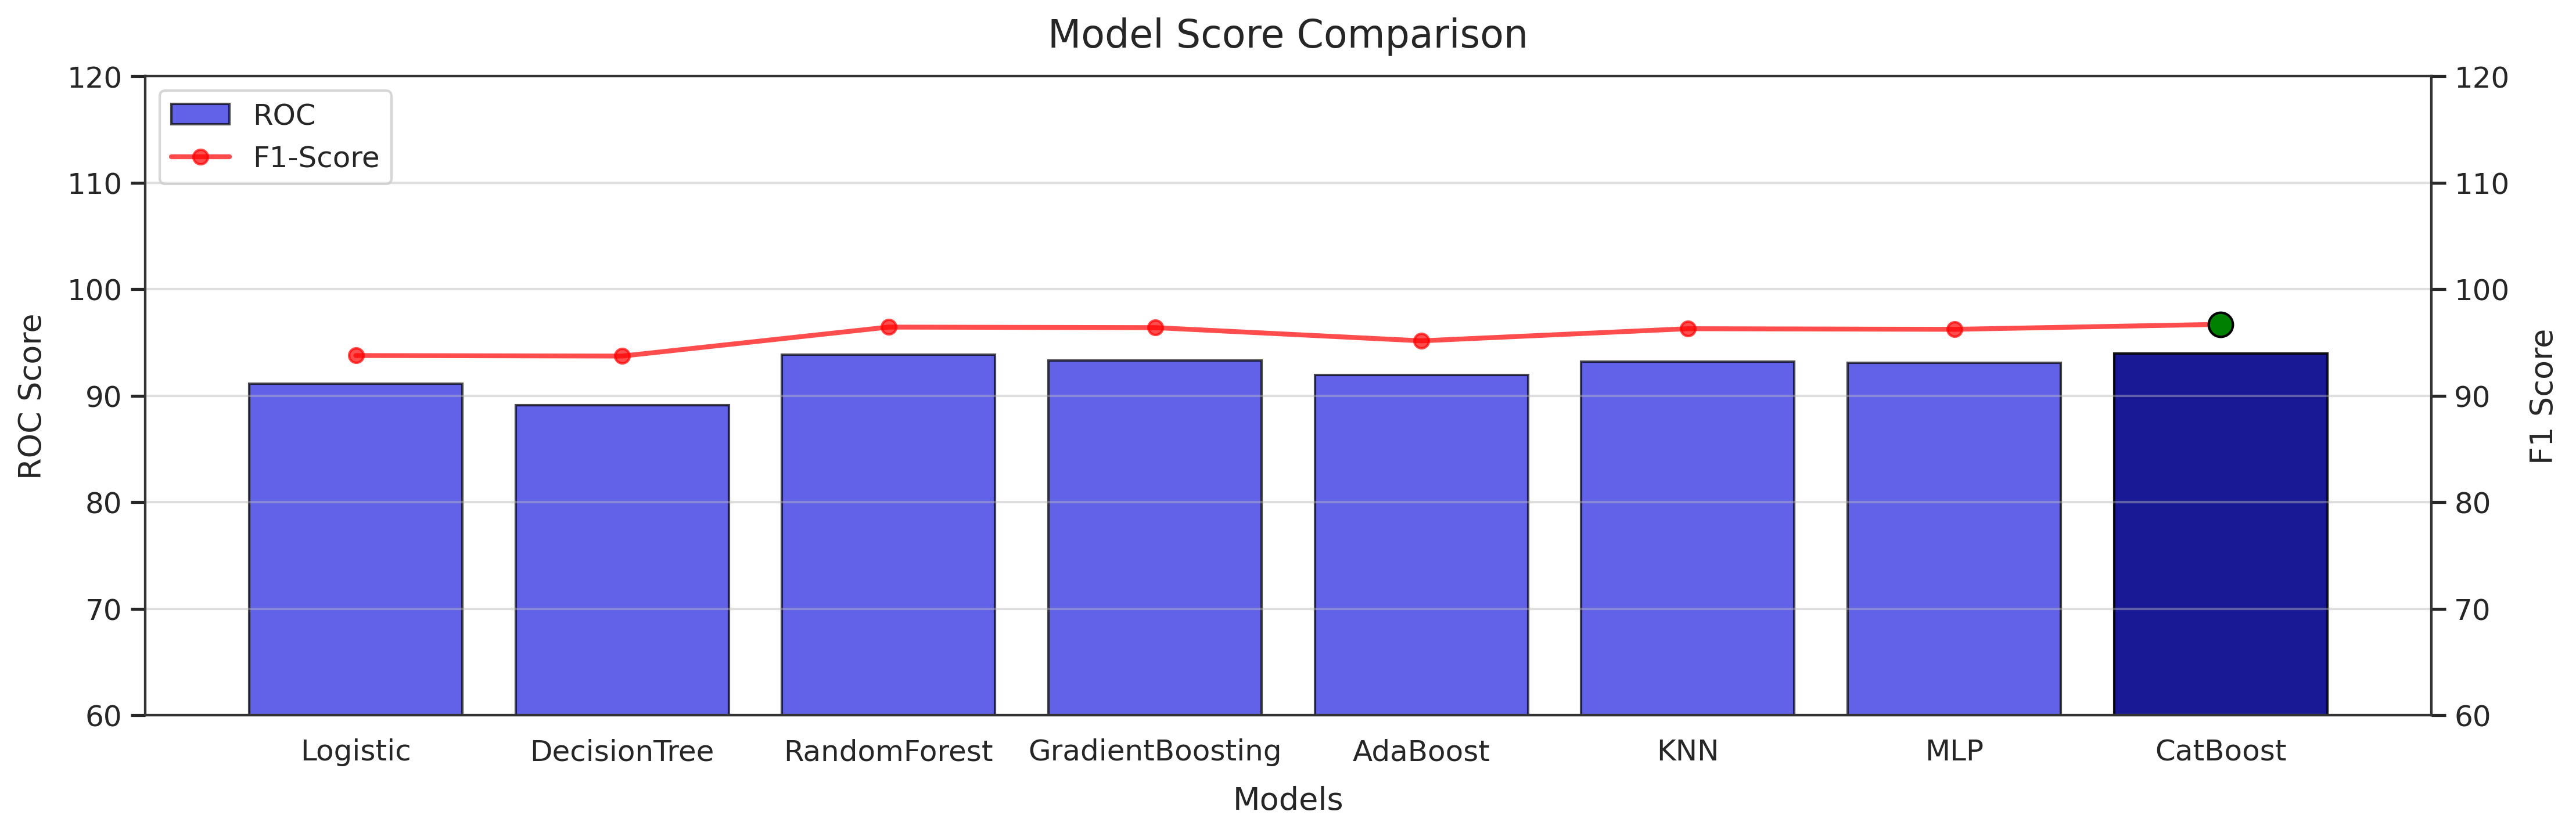

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot all ROC bars except the last one
sns.barplot(
    x="ModelNames",
    y="ROC",
    data=modelMetrics.iloc[:-1],
    color='blue',
    edgecolor='black',
    alpha=0.7,
    ax=ax,
    label='ROC'
)

# Plot the last ROC bar differently
last_idx = modelMetrics.index[-1]
ax.bar(
    modelMetrics.loc[last_idx, 'ModelNames'],
    modelMetrics.loc[last_idx, 'ROC'],
    color='darkblue',
    edgecolor='black',
    alpha=0.9
)

# Plot the F1-score as a line
ax2 = ax.twinx()
ax2.plot(
    modelMetrics['ModelNames'],
    modelMetrics['F1'],
    color='red',
    marker='o',
    linewidth=2,
    alpha=0.7,
    label='F1-Score'
)

# Highlight last F1-score marker differently
ax2.plot(
    modelMetrics.loc[last_idx, 'ModelNames'],
    modelMetrics.loc[last_idx, 'F1'],
    marker='o',
    markersize=10,
    markerfacecolor='green',
    markeredgecolor='black',
)

# Axis and title
ax.set_xlabel("Models")
ax.set_ylabel("ROC Score")
ax2.set_ylabel("F1 Score")
ax.set_ylim(60, 120)
ax2.set_ylim(60, 120)
plt.title("Model Score Comparison")


handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Tight layout
plt.tight_layout()
plt.savefig(f"{figure_directory}/SciFi_ModelCompare.png")
plt.show()
